Pedro Siade Ferreira

202004734

Tarefa2) Pesquise/Implemente o Canny Edge Detector – O algoritmo de detecção de bordas desenvolvido por Canny é considerado o “estado da arte” em detecção de bordas. É uma verdadeira evolução depois do algoritmo de Marr-Hildreth já mencionada em classe. O processo possui etapas que utiliza conceitos/filtros que você já implementou nessa disciplina e algumas regras/conhecimentos heurísticos.

A tarefa aqui consiste em compreender e implementar o operador/algoritmo de Canny tal como apresentado nos
livros do Gonzalez e Burger. Ele é mais bem apresentado no livro do Burger (pág. 132), onde um algoritmo é
detalhado.

Existem diferentes tutoriais na Internet e artigo na Wikipédia. Alguns exemplos:
https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html
https://acervolima.com/implementar-canny-edge-detector-em-python-usando-opencv/
a) Faça uma apresentação estilo .pptx explicando cada passo/etapa do processo de detecção de bordas
desenvolvido por Canny. Ilustre cada passo de sua apresentação. Capriche, sua nota depende também disso.
Submeta no G. Classroom o arquivo Tarefa2A.pptx e se prepare para apresentar caso sorteado(a).
b) Faça a implementação em Python (não copie!) e a descreva em um Jupyter Notebook Tarefa2B.ipynb.
Submeta seu Jupyter Notebook no G. Classroom. Não se esqueça de colocar a(s) imagen(s) utilizados no
mesmo arquivo .zip.


In [69]:
%matplotlib inline
import cv2 # importa opencv
import numpy as np # importa numpy
import matplotlib.pyplot as plt
import sys
import math
import time

Passos do algoritmo de Canny:

1.Filtragem para redução de ruídos usando filtro gaussiano

2.Calculo do gradiente

3.Supressão não máxima de bordas falsas

4.Limiar duplo para segregar bordas fortes e fracas

5.Rastreamento de borda por histerese



O algoritmo de Canny representa uma evolução do algoritmo de sobel, o segundo é um excelente detector de bordas, no entanto Canny buscou aperfeiçoa-lo delimitando quais pixels são os mais importantes a fim de afinar a borda em questão, bem como a direção da mesma entra no processo.

In [70]:
def filtroTamanhoArbitrario(img, filtro):
  M, N = img.shape
  s = 1 / np.sum(filtro) #suma dos coeficientes da matriz do filtro a fim de normalizar a mesma
  K = int(math.floor(len(filtro[0]) / 2))
  L = int(math.floor(len(filtro) / 2))
  imgFiltrada = img.copy() #copia da imagem a fim de não modificar a principal e causar erros
  for v in range(L, N - L):   #Como range varia de L ate N-L-1, diferentemente do cod em java do livro, aqui será N-L
    for u in range(K, M - K):
      sum = 0
      for j in range(-L, L+1):
        for i in range(-K, K+1):
          p = img[u+i, v+j]
          c = filtro[j+L-1][i+K-1]
          sum = sum + (c * p)
      q = np.round(sum * s)
      if q < 0:
         q = 0
      elif q > 255:
         q = 255
      imgFiltrada[u, v] = q
  return imgFiltrada

In [71]:

def montarFiltroGaussiano(m,n, sigma):
  h = np.zeros((m,n), dtype = np.float32)
  a = (m-1)/2
  b = (n-1)/2
  for x in range(m):
        for y in range(n):
              h[x,y] =np.exp(-(((x-a)**2) + ((y-b)**2))/(2*(sigma**2)))
  h = h/np.sum(h)
  return h

In [72]:
sobel= np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
])
sobel2= np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

1.Lendo a imagem e realizando a filtragem da mesma com um filtro gaussiano:

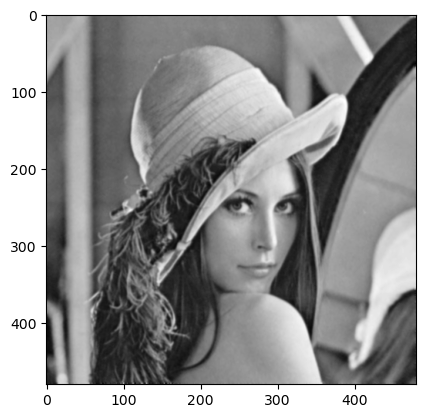

In [73]:
img = cv2.imread('imagens/1_original.jpg', cv2.IMREAD_GRAYSCALE)
g33=montarFiltroGaussiano(5,5, 1)
img_gaussiana=filtroTamanhoArbitrario(img, g33)
plt.imshow(img_gaussiana, cmap='gray')


2.Aplicando a mascará de Sobel na imagem, calculando o gradiente a tg dos angulos. 


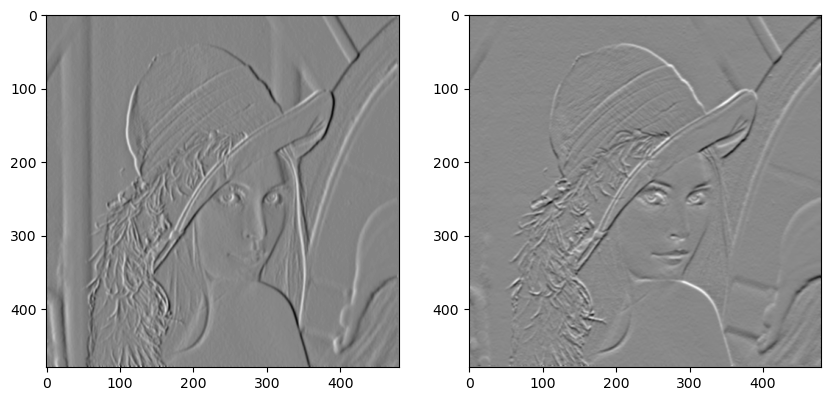

In [74]:
gx = cv2.Sobel(img_gaussiana, cv2.CV_32F, 1, 0,3)
gy = cv2.Sobel(img_gaussiana, cv2.CV_32F, 0, 1,3)
fig = plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(gx,cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(gy,cmap = 'gray')


488.89465
359.81815


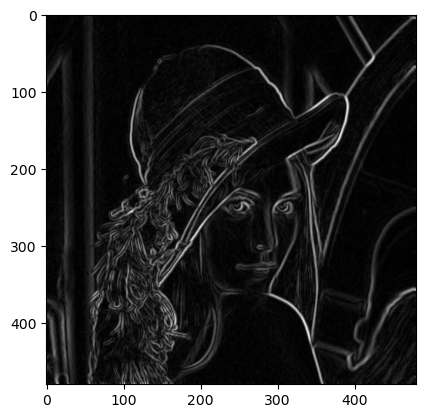

In [75]:
mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)
plt.imshow(mag, cmap='gray')
print(np.max(mag))
print(np.max(ang))

3. Superessão não máxima:

Nesta etapa, a direção dos ângulos de cada pixel na imagem é estabelecida usando os algoritmos de Sobel. Isso é realizado através do cálculo da tangente das derivadas nas direções vertical (y)/ horizontal (x). Logo, com esse cálculo é possível identificar os dois vizinhos mais relevantes na direção específica, sendo posteriormente efetuadas comparações entre esses elementos com o intuito de decidir se o pixel em análise será mantido ou descartado. Como resultado desse processo, é gerada uma nova matriz binária, composta pelos pixels considerados mais relevantes.

Intervalo 0 - 180:
180/4=45° - então cada intervalo tem 45°

Exemplo:

Artg dy/dx=45°

[
[(i-1, j-1),(i-1, j),(i-1, j+1)],
[(i, j-1),(i, j),(i, j+1)],
[(i+1, j-1),(i+1, j),(i+1, j+1)]
]


Na matriz apresentada, em que o ângulo do pixel A[i,j] é de 45°, identificamos que os vizinhos a serem considerados nessa mesma direção, serão : (i-1, j+1) e (i+1, j-1).

Uma vez selecionados esses vizinhos, procedemos à comparação entre o valor do pixel A[i,j] e o valor dos vizinhos. Caso o valor do pixel seja maior que o valor dos vizinhos, ele é mantido inalterado. No entanto, caso contrário, ele é definido como nulo.

Esse procedimento é aplicado a toda a matriz, permitindo a determinação dos pixels mais relevantes, visando preservar as características da borda. Sendo assim, o objetivo é reter esses elementos essenciais com a menor quantidade possível de pixels, buscando uma representação mais refinada da borda.



In [76]:
def NonMaximumSuppression(img, angle):
 M, N = img.shape
 Z = np.zeros((M,N), dtype=np.int64)
 for i in range(1,M-1):
    for j in range(1,N-1):
        q = 255
        r = 255
        # definição dos intervalos e vizinhos:
        if (0 <= angle[i,j] < 22.5) or (angle[i,j] > 337.5)  :
            r = img[i, j-1]
            q = img[i, j+1]

        elif (22.5 <= angle[i,j] < 67.5) or (202,5<angle[i,j] < 247.5):
            r = img[i+1, j+1]
            q = img[i-1, j-1]

        elif (67.5 <= angle[i,j] < 112.5) or (247.5<angle[i,j] < 13*180/8):
            r = img[i-1, j]
            q = img[i+1, j]

        else:
            r = img[i-1, j-1]
            q = img[i+1, j+1]

            #comparação entre os vizinhos e o pixel analisado:
        if (img[i,j] >= q) and (img[i,j] >= r):
            Z[i,j] = img[i,j]
        else:
            Z[i,j] = 0
 return Z

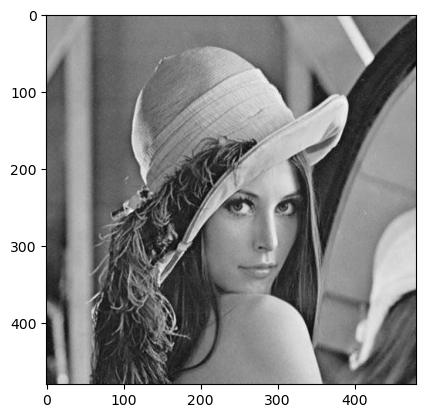

In [77]:
imgsuprimida=NonMaximumSuppression(mag, ang )
plt.imshow(img, cmap='gray')

4.Limiar duplo para segregar bordas fortes e fracas:
São definidos dois lineares, como na linearização ja visto anteriormente. 
Sendo:

Linear1<Linear2, H[i,j] um pixel da imagem, então:
            
Se H[i,j]<linear 1-> H[i,j] então H[i,j]=0
Se linear 1<H[i,j]<linear 2-> então H[i,j]=1
Se H[i,j]>linear então H[i,j]= 2

O estabelimento dos dois lineares serve para delimitar bordas que devem ser desprezadas, bordas menos importante, menor intesnidade, e bordas mais importante, bordas de maior intensidade.



In [78]:
def limiarização(img, weak, strong):
    M,N=img.shape
    img2 = img.copy()
    for x in range(M-1):
        for y in range(N-1):  
            aux = img[x, y]  
            if aux<weak: #limite inferior-> menor=0
                mag[x, y]= 0
            elif strong>aux>= weak: #entre limite inferior e superior
                #intensidade intermediaria
                img2[x, y]= 50
            else:# o resto intensidade maxima
                img2[x, y]= 200
    return img2

In [79]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.20):
    highThreshold = img.max() * highThresholdRatio;#definição dos lineares
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)#definição das intensidades
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)#condicionais
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)
 

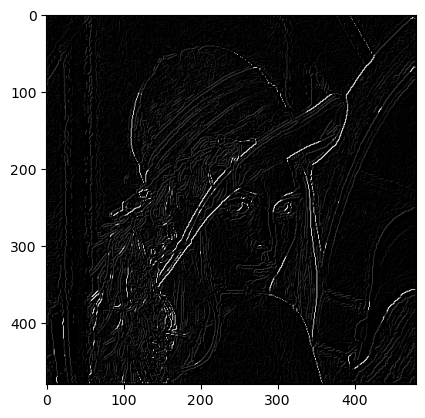

In [80]:
imglimiar1= limiarização(imgsuprimida, 50,200)
plt.imshow(imglimiar1, cmap='gray')

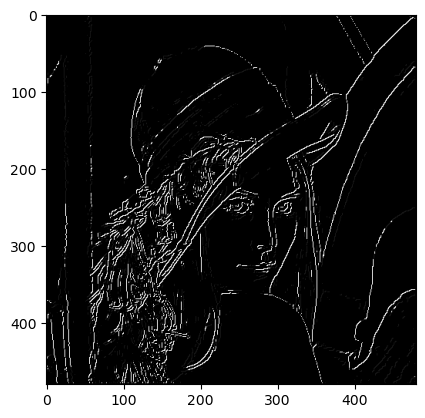

In [81]:
imglimiar2= threshold(imgsuprimida, 0.5)[0]
plt.imshow(imglimiar2, cmap='gray')


Nessa parte por meio de pesquisas encontrei várias formas de realizar. Sendo que a primeira representa um algoritmo baseado na do 'arcevolima' indicação do trabalho, desenvolvendo assim um algoritmo próximo ao proposto oqual funciona como o mesmo. Já a segunda encontrei em pesquisas contida na referência, comparando o resultado entre ambos foi possíve chegar a resultados proximos, principalmente no passo a seguir.

6.Rastreamento Histerese:

Nessa parte é avaliado a vzinhança das bordas 'fracas', se na mascara 3x3 houve um pixel 'forte', então o pixel fraco será considerado na imagem binária, caso contrário não.


In [82]:
def rastreamentoHisterese(img, weak, strong):
    M, N = img.shape
    aux= np.zeros((M,N), dtype=np.int64)
    for i in range(1, M-1):
        for j in range(1, N-1):
            aux2=0
            if(img[i,j]==weak):
                for k in range(-1, 1):
                     for l in range(-1, 1):
                            if[img[i+k,j+l]==strong]:
                                aux2=2
                if(aux2==2):
                    aux[i,j]=strong
                else :
                    aux[i,j]=0
                
            elif(img[i,j]==strong):
                aux[i,j]=strong
            else:
                aux[i,j]=0
    return aux
                            
    

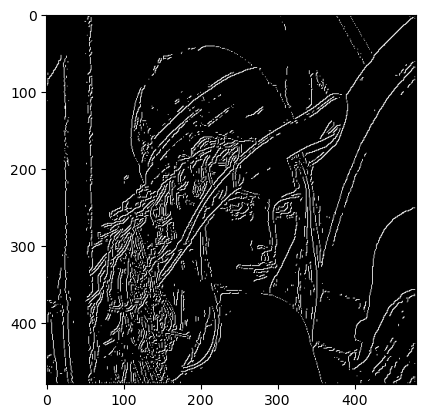

In [83]:
imgfinal=rastreamentoHisterese(imglimiar1, 50, 200)
plt.imshow(imgfinal, cmap='gray')

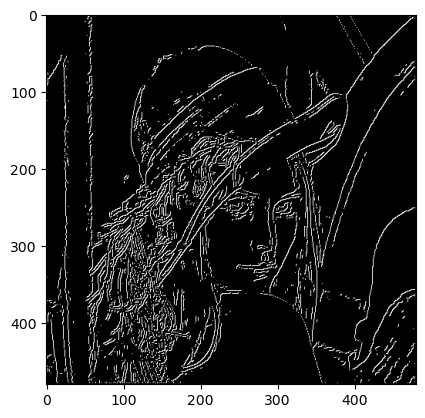

In [84]:
imgfinal2=rastreamentoHisterese(imglimiar2, 25, 255)
plt.imshow(imgfinal2, cmap='gray')

Os dois algoritmos obtiveram resultados satisfatórios, bem proximos.

Pelo fato de ter sido realizados todos passos de acordo com o livro e material fornecido, conclui que os resultados estavam de acordo com o esperado.

Outros testes:

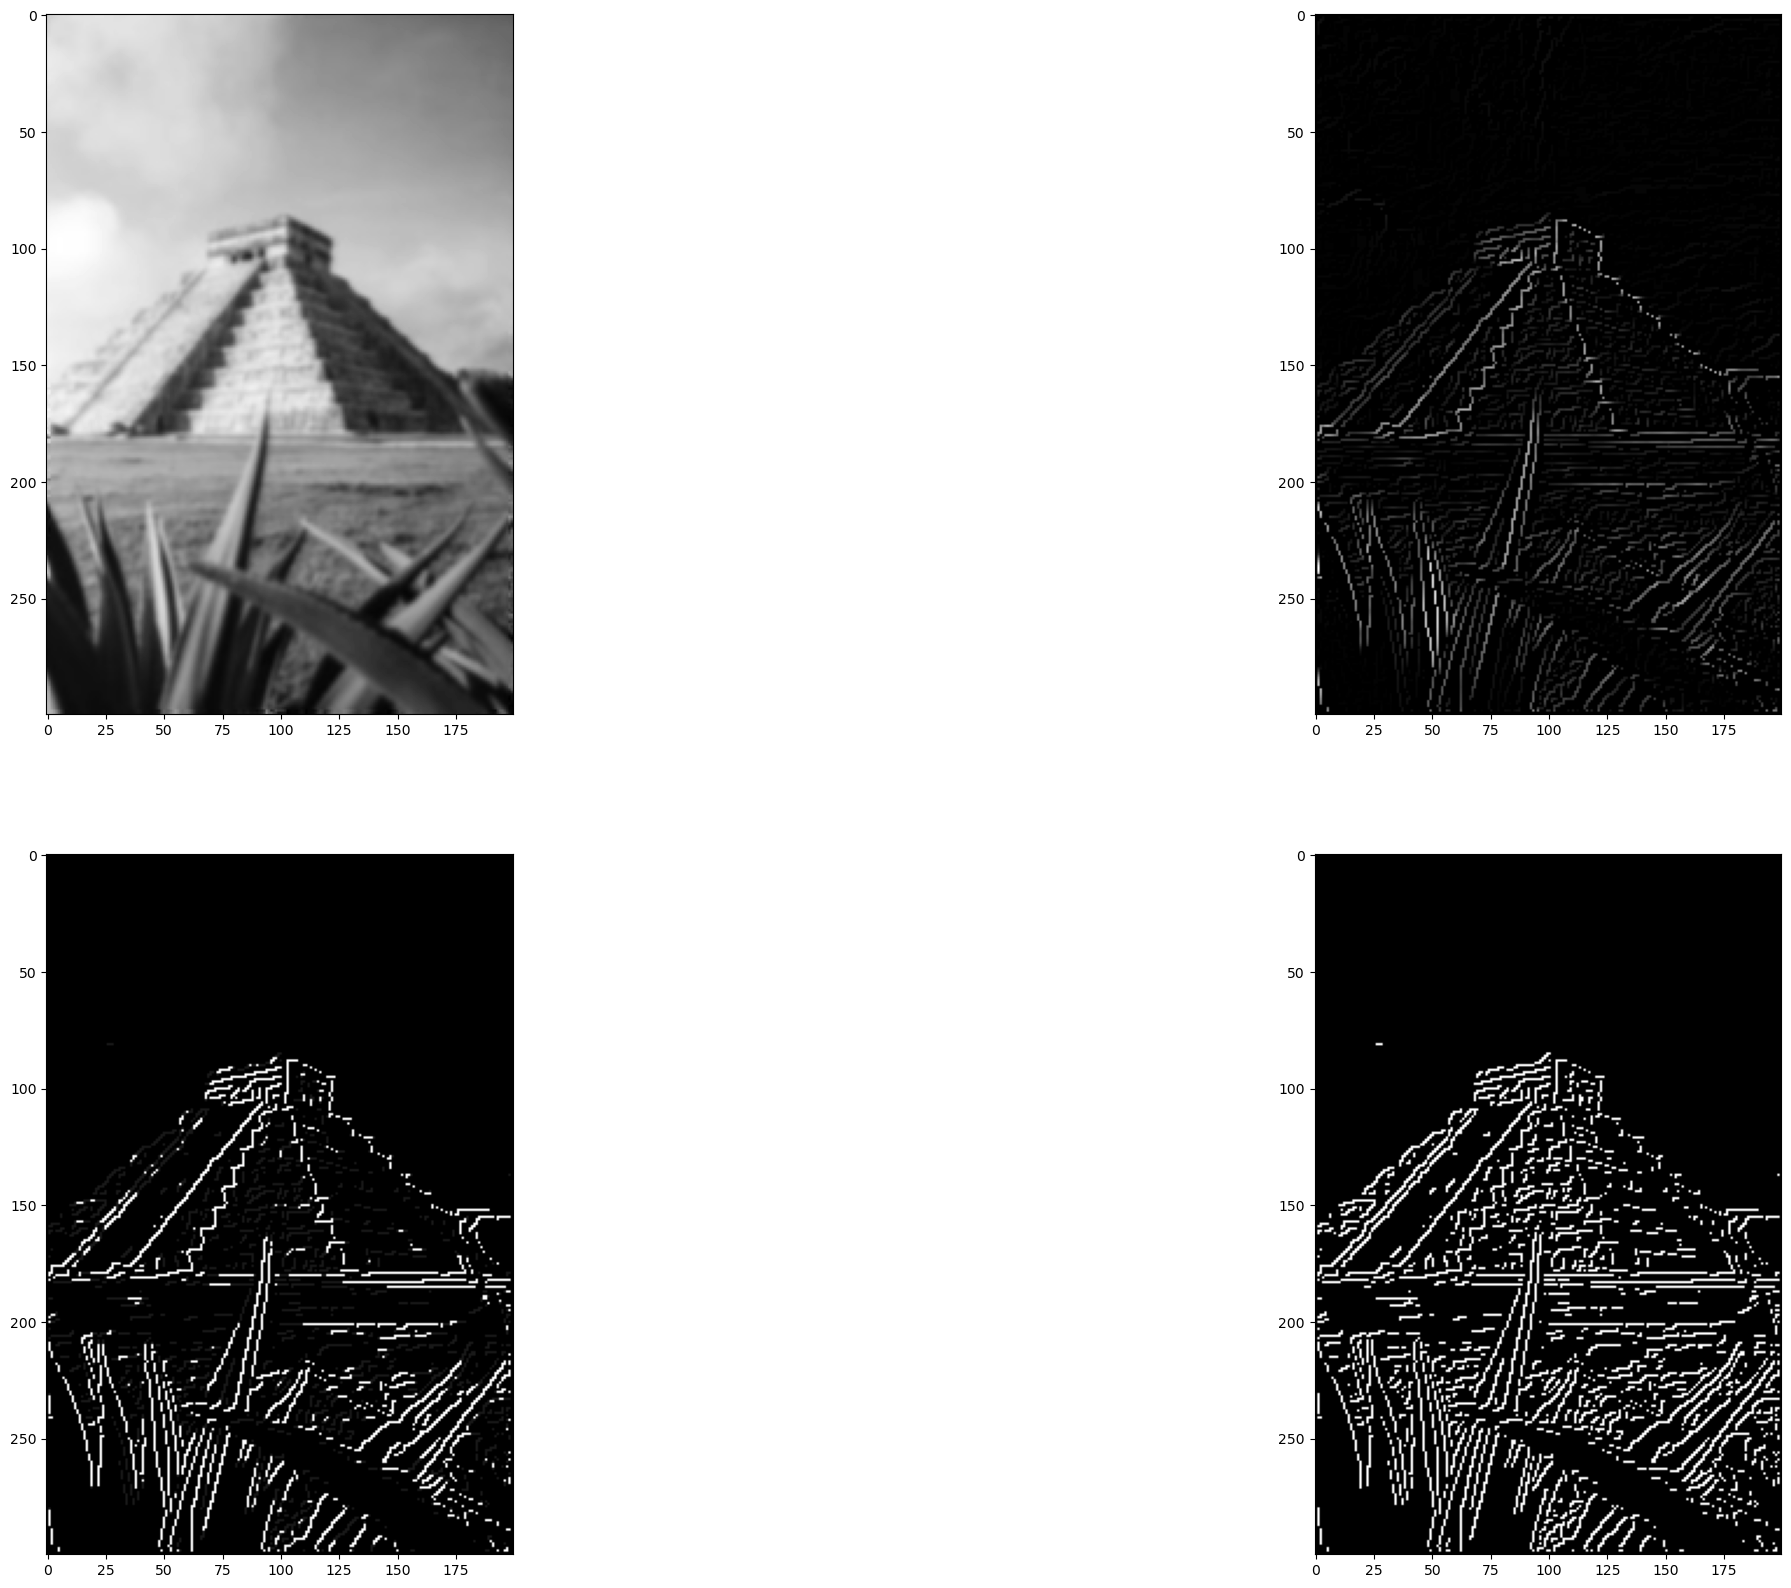

In [85]:
img2 = cv2.imread('imagens/imgPiramide.jpeg', cv2.IMREAD_GRAYSCALE)
img_gaussiana2=filtroTamanhoArbitrario(img2, g33)
gx2 = cv2.Sobel(img_gaussiana2, cv2.CV_32F, 1, 0,3)
gy2 = cv2.Sobel(img_gaussiana2, cv2.CV_32F, 0, 1,3)
mag2, ang2 = cv2.cartToPolar(gx2, gy2, angleInDegrees = True)
imgsuprimida2=NonMaximumSuppression(mag2, ang2 )
imglimiar3= threshold(imgsuprimida2, 0.5)[0]
imgfinal3=rastreamentoHisterese(imglimiar3, 25, 255)
fig = plt.figure(figsize=(30,20))
plt.subplot(2, 2, 1)
plt.imshow(img_gaussiana2, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(imgsuprimida2, cmap='gray')
plt.subplot(2, 2, 3)
plt.imshow(imglimiar3, cmap='gray')
plt.subplot(2, 2, 4)
plt.imshow(imgfinal3, cmap='gray')




Observação: durante minhas pesquisa foi obersavado vários algoritmos para a supressão nao maxima, sendo o acima com melhor desempenho, portanto o escolhido.

Com todos os exemplos acima fica claro a eficiência do algoritmo de canny, sendo bastante complexo e de bastante funcionalidade, ententendo assim como os detectores de  bordas atuais tendem a funcionar.

referencias: 
https://medium.com/@rohit-krishna/coding-canny-edge-detection-algorithm-from-scratch-in-python-232e1fdceac7
https://www.geeksforgeeks.org/implement-canny-edge-detector-in-python-using-opencv/